In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

前章で見たRNNは「シンプルなRNN」や「エルマン」と呼ばれ，時系列データの彫金お依存関係をうまく学習することができない問題点があった．  
最近ではRNNという言葉が使われるときにはLSTMであることが多く見受けられる．  
LSTMやGRUには「ゲート」と呼ばれる仕組みを持ち，長期的な依存関係を学習することができるようになっている．  
<br>
この章では「ゲート付きRNN」をテーマにLSTMを使って言語モデルを作り，実際のデータでうまく学習できる事を示す．

# まとめ
単純なRNNの改良を行った．  
逆伝播の際，行列同士の積がひたすら時間方向に続き，勾配が指数的に大きく/小さくなっていくことで勾配爆発/消失が発生してしまう．  

- 勾配爆発
    - 勾配クリッピングで解決
        - 勾配の閾値を設け，その閾値を超えたら超えた分に応じて係数をかけ，大きくなりすぎた勾配を小さくする．
- 勾配消失
    - ゲート付きRNNで解決
        - ゲートは情報をどれだけ通すかを決める0.0~1.0の値の集合，ゲートでの計算結果はシグモイド関数で[0,1]に正規化される．
        - GRU: 付録C, Gated Recurrent Unit, LSTMよりパラメータが削減されていて高速
        - LSTM： 今回の主役，代表的なものは，以下のような仕組みを持つ
            - 記憶セル
                - 時刻tでの出力単語の他に，その単語を出力した時に使った記憶を，出力単語とは別に時間方向に伝播させるためのインタフェース
                - 記憶セルに関する計算は全て行列の積ではなく要素ごとの掛け算(アダマール積)で行われるため，勾配消失が起きにくい．
                - これにより，リアルタイムな短期記憶(short-term memory)を長い(Long)RNNブロックで覚えておく(コンテキストとして考慮できる)ことができるようになる．
            - forgetゲート: f
                - 入力された記憶セルの中から，各情報をどれだけ忘れるかを調整するゲート
                - 忘却はより良い前進を産む
            - inputゲート: i
                - 入力された記憶セルに，新しい情報をどれだけの重要度で覚えさせるかを調整し，記憶セルに追加するゲート
                - 次の記憶セルに渡す情報を決定する．
                - 新しい情報: g
                    - 前の時刻に出力された単語(の分散表現)と入力単語から算出される情報で，ゲートとは違い,tanhで[-1, 1]に正規化される．
            - outputゲート: o
                - 更新された記憶セルの情報に，前の時刻に出力された単語(の分散表現)と入力単語をどれだけ加味するかを調整するゲート
                - 出力単語(の分散表現)を決定する．
- 言語モデルの改良テクニック
    - LSTMレイヤの多層化
        - モデルがより複雑な問題に対応できるようになる．
    - Dropout
        - 複雑さにペナルティを与える正則化の効果があり，過学習を防ぐ
        - 深さ方向： 普通に実装
        - 時間方向: 変分DropoutでDropoutする重みの位置を層ごとに固定
    - 重み共有
        - 一部の層で重みを共有することでパラメータを削減し，複雑さを軽減させて過学習を防ぐ
        - 入力側のEmbeddingレイヤの重みをAffineレイヤで利用

最新のモデルでは，重みそのものをランダムで無視するDropConnectや，8章のAttentionをベースとするcontinuous cache pointerなどが利用されており，その精度はパープレキシティ(絞りきれなかった次の単語の候補の数の相場)は50程度にまで抑えられている．  
本章で実装した言語モデルでは，LSTMを用いたもので135程度,改良テクニックを使ったもので75程度のパープレキシティを出すことができる．

# RNNの問題点
RNNはBPTT（Backpropergation Through Time)において勾配消失もしくは勾配爆発が起こるため，長期記憶を苦手としている．  
RNNが長期記憶を苦手とする理由を実例を使って見ていく．

## RNNの復習
RNNレイヤはループする経路を持ち，展開すると横に長く伸びるネットワークになる．  
RNNレイヤは時系列データ$x_1, x_2, ... x_t$を入力として持ち$h_1, h_2, ..., h_t$を出力する．  
この$h_t$はRNNレイヤの**隠れ状態**と呼ばれ，過去からの情報が記憶されており，各時刻におけるRNNレイヤは，一つ前の時刻の隠れ状態を利用する．  
$x_t, h_{t-1}$から$h_t$を出力する式は以下のようになり，この式にしたがってRNNレイヤを構成する．
$$h_t = \tanh( h_{t-1} W_h + x_t W_x+ b ) $$

## 勾配消失もしくは勾配爆発
前章のRNNLMのような言語モデルが行うことは，これまでに与えられた単語から次に出現する単語を予測すること．  
例えば，
    <div style="text-align: center">Tom was watching TV in his room. Mary came into the room. Mary said hi to [?]</div>
    
という文章について，[?]に入る単語はTomになる．  
RNNLMに正解ラベルとしてTomという単語が与えられたとき，勾配がどのように伝播するかを考えてみる．  
本来，勾配には学習すべき意味のある情報が入っており，過去に向かって伝わっていく.  
しかし，もしこの勾配が途中で弱まってしまったら，過去にいくほど重みパラメータは更新されなくなってしまう．  
残念ながら，シンプルなRNNでは時間を遡るにしたがって勾配が小さくなっていく(勾配消失)もしくは無駄に大きくなっていく(勾配爆発)がほとんどである．

## 勾配消失もしくは勾配爆発の原因
RNNレイヤの時間方向だけの勾配の伝播だけに着目してみる  
RNNレイヤの活性化関数であるtanhとtanhの微分をそれぞれグラフにしてみる．

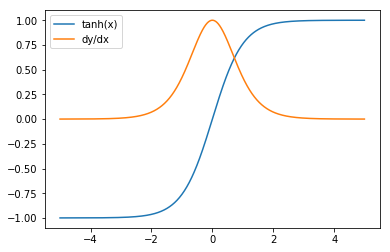

In [2]:
import math

x = np.arange(-5, 5, 0.01)
tanh = np.array([math.tanh(x_i) for x_i in x])
tanh_prime = 1 - pow(tanh, 2)
plt.plot(x, tanh, label="tanh(x)")
plt.plot(x, tanh_prime, label="dy/dx")
plt.legend() # matplotlibの凡例: https://qiita.com/matsui-k20xx/items/291400ed56a39ed63462
plt.show()

このグラフの通り，dy/dxは最大値が1.0であり，そこから離れるごとに0に近づくので，このtanhノードを通るたびに勾配は小さくなっていく．  
T回tanhを通過すればT回値が小さくなる． これが勾配消失の原因になっている．  
活性化関数にReLUを使えば，ReLUの式$\max(0, x)$を使って上流の勾配をそのまま下流に伝えることができ．勾配の劣化を起こさず性能が向上することがわかっている．

次にMatMulノードの逆伝播を見てみる．  
MatMulノードの逆伝播では$dhW_h^\top$による行列の積によって勾配が計算される．  
この行列の席の計算では，毎回同じ重み$W_h$が使われることに注意する．  
逆伝播の際の勾配の値は，MatMulノードを通るのに従ってどのように変化していくのかを観察してみる．  

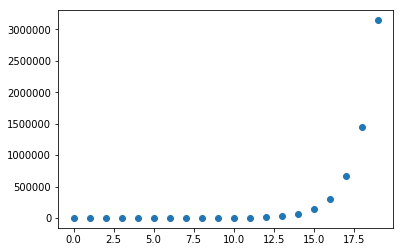

In [3]:
N = 2 # バッチサイズ
H = 3 # 隠れ状態ベクトルの次元数
T = 20 # 時系列データの長さ

dh = np.ones((N, H)) # 上からやってくる勾配の計算
# np.random.seed(3) # 再現性のため乱数のシードを固定
Wh = np.random.randn(H, H) # 実験1,重みの初期値そのまま

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T) # MatMulノードの逆伝播の計算
    norm = np.sqrt(np.sum(dh**2)) / N # L2ノルムで行列全体の大きさの相場をスカラで表す
    norm_list.append(norm)

plt.scatter(range(T), norm_list)
plt.show()

グラフから分かるように，勾配の大きさは時間とともに指数的に増加する．これが**勾配爆発**である．  
最終的にはオーバーフローを起こしてNaNのような値が発生してしまう．  

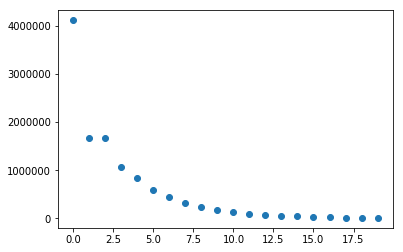

In [4]:
Wh = np.random.randn(H, H) * 0.5 # 実験2, 重みの初期値に0.5をかける

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T) # MatMulノードの逆伝播の計算
    norm = np.sqrt(np.sum(dh**2)) / N # L2ノルムで行列全体の大きさの相場をスカラで表す
    norm_list.append(norm)

plt.scatter(range(T), norm_list)
plt.show()

逆に，重みの初期値を小さくしてみると，**勾配消失**が発生する．  
Tが大きいとき，$W_h$は今行列だが，例えばスカラであるとすると，$W_h$が1より大きいときには勾配爆発，小さいときには勾配消失が起きるというイメージになる.  


$W_h$が今のように行列の場合は，行列の「特異値」が勾配爆発，もしくは消失の指標となる．  
行列の「特異値」は，データにどれだけ広がりがあるかをあらわし，これが1より大きいかどうかで，勾配の大きさの変化を予測することができる．  
RNNの勾配消失/爆発については文献[30]に譲るが，特異値が1より大きい ⇦ 勾配爆発が発生 であり，ここでは必要条件となっていることに注意する．  
しかし， 特異値が1より小さい ⇨ 勾配消失が発生 は成り立つ．

## 勾配爆発への対策
勾配クリッピング
$$ \rm{if} ||\hat{g}|| \geq threshold: \hat{g} = \frac {threshold} {||\hat{g}||} \hat{g} $$
単純だが多くの場合うまくいくらしい  
ここで$\hat{g}$は取り扱う全ての重みを結合したもの．  
例えば$W_1, W_2$をモデル内で使うなら，$||\hat{g}|| = \sqrt{W_1^2 + W_2^2}$となる．  
ここで$W_i^2$は行列$W_i$のそれぞれの要素を全て2乗するという意味．ルートも同じ．

In [5]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0 # Threshold

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    # total_norm >= threshold  ==> total_norm+delta > threshold  ==> threshold/(total_norm+delta) < 1 ==> rate < 1
    rate = max_norm / (total_norm + 1e-6) # ゼロディビジョン対策
    if rate < 1:
        for grad in grads:
            grad *= rate

clip_grads(grads, max_norm)

# 勾配消失とLSTM
こっちはRNNレイヤのアーキテクチャを根本から変える必要がある．  
ここで登場するのが「ゲート付きRNN」  
本節ではLSTMにフォーカスし，勾配消失を起こさない(起こしにくい)ことを明らかにする．  

## LSTMのインタフェース
計算グラフ上で，RNNの$h_t$の計算をひとまとめにしてtanhノードとする．  
<br>
RNNとLSTMの違いは，**記憶セル**$c_{t-1}$(入力), と$c_{t}$(出力)を持っていること．  
この記憶セルは隠れ状態ベクトル$h_t$と違って外部には見えず，その存在を外部から考える必要はない．  

## LSTMレイヤの組み立て
記憶セル$c_t$には，過去から時刻$t$までのLSTMに必要な記憶が格納されている．  
この$c_t$は，$c_{t-1}$と$h_{t-1}$から，以降説明する計算によって算出され，次の時刻のLSTMレイヤへ直接出力される．  
ここで，$c_t$と$h_t$は同じ要素数を持つ．

「ゲート」とは門のことで，データの流れをコントロールする．  
LSTMのゲートは開く/閉じるの二択ではなく，0~1.0の範囲でどれくらいの量の水を次へ流すかをコントロールする．  
この「どれだけゲートを開くか」ということもデータから学習させ，専用の重みパラメータを更新する．  
ゲートの開き具合を求めるときには，sigmoid関数を用いる.

## outputゲート
今，LSTMの仕組みから，$h_t = \tanh(c_t)$である．  
この$\tanh(c_t)$に対してゲートを適用する．  
outputゲートの開き具合は，入力$x_t$と前の状態$h_{t-1}$から求める．  
ゲートで使用する重みパラメータとバイアスについては，上添字にoutputの頭文字である$o$をつけて区別する．  
また，シグモイド関数は$\sigma()$で表す．  
出力ゲートの値の式を以下に示す．  
$$ o = \sigma(x_t W_x^{(o)} + h_{t-1}W_h^{(o)} + b^{(o)}) $$
このoutputゲートで行う計算を計算グラフ上では「σ」と表す．  
Sigmoid関数を用いているため，$o$の各要素は0.0~1.0であり，ゲートの役割を持つことができる．  
これにより，出力$h_t$は以下の式で計算される．  
$$ h_t = o \odot \tanh(c_t) $$
ここで$\odot$はアダマール積と呼ばれ，同じ要素番号の要素同士の積をとる演算子である．  


## forgetゲート
次に，記憶セルに対して何を忘れるかを明示的に示してやる，forgetゲートを追加する．  
forgetゲートの式は以下で表される．形はoutputゲートと同じで，別途専用の重みを使用する．  
$$ \rm{f} = \sigma(x_t W_x^{(\rm{f})} + h_{t-1}W_h^{(\rm{f})} + b^{(\rm{f})}) $$
計算グラフ上では，forgetゲートも$\sigma$を使って表される．  
この$\rm{f}$を使って，$c_t$は$c_{t-1}$より以下の式で計算される．  
$$ c_t = c_{t-1} \odot \rm{f} $$
現在，この$c_t$を使って，$h_t = \tanh(c_t)$と計算されている.  これからまた色々ゲートを足していく．  

## 新しい記憶セル
forgetゲートで忘れるだけではなく，新しく覚えるべき情報を記憶セルに追加する．  
$$ \rm{g} = \tanh(x_t W_x^{(\rm{g})} + h_{t-1}W_h^{(\rm{g})} + b^{(\rm{g})}) $$
計算グラフ上では，この新しい記憶セルは$\tanh$を使って表される．  
この$\rm{g}$を$c_{t-1}$に加算することで新しい記憶が生まれる．  
現在， $c_t = c_{t-1} \odot \rm{f} + \rm{g} $, $h_t = o \odot \tanh(c_t) $である．  

# inputゲート
最後に，新たに追加する情報$\rm{g}$がどれだけ価値があるかを判断するinputゲートを追加する．  
このinputゲートによって，何も考えずに新しい情報を追加するのではなく，追加する情報の取捨選択を行う．  
$$ \rm{i} = \sigma(x_t W_x^{(\rm{i})} + h_{t-1}W_h^{(\rm{i})} + b^{(\rm{i})}) $$
計算グラフ上では，この新しい記憶セルも$\sigma$を使って表される．
そして，iとgの要素ごとの席の結果を記憶セルに追加する．  
最終的に，
$$ c_t = c_{t-1} \odot \rm{f} + \rm{g} \odot \rm{i} $$
$$ h_t = o \odot \tanh(c_t) $$
という計算になる．

ここまでのLSTMは代表的なもので，他にも色々亜種がある．

## LSTMの勾配の流れ
上述のLSTMがなぜ勾配消失を起こさないのかを記憶セル$c$の逆伝播に注目して見てみる．  
<br>
$c_t$から$c_{t-1}$への逆伝播では，「＋」ノードと「×」ノードを通る．  
「＋」ノードの逆伝播は，そのまま下流に上流のデータを流すので劣化が起きない．  
「×」ノードの逆伝播は，今までは行列の積の逆伝播でデータの劣化が起きていたが，今はアダマール積の逆伝播である．  
<br>
「×」ノードでは，forgetゲートのゲート値がアダマール積でかけられている．  
このforgetゲートのゲート値が大きければ下流に伝わる勾配は大きくなり，逆もまた然りとなる．  
これは，forgetゲートが「忘れてはいけない」と導いた要素の勾配は劣化させず，逆もまた然り，ということである．  
<br>
以上の議論から，LSTMの記憶セルでは，重要とされた記憶を長期的に保持することができ，勾配消失が起きない/起きにくいことが分かる．  

LSTMとは，Long short-term memoryの頭文字から来ている．  
この言葉は，短期記憶(short-term memory)を長い(long)時間継続できることを意味する．

# LSTMの実装
まず1ステップの処理をLSTMクラスとして実装した後，Tステップ文をまとめて処理するクラスをTimeLSTMとして実装する．  
まずはLSTMで行う4つのゲート計算を一つにまとめて計算を効率化するところから始める．  
$$ \begin{eqnarray*} \\
\rm{f} &=& \sigma(x_tW_x^{(\rm{f})} + h_{t-1}W_h^{(\rm{f})} + b^{(\rm{f})}) \\
\rm{g} &=& \tanh(x_tW_x^{(\rm{g})} + h_{t-1}W_h^{(\rm{g})} + b^{(\rm{g})}) \\
\rm{i} &=& \sigma(x_tW_x^{(\rm{i})} + h_{t-1}W_h^{(\rm{i})} + b^{(\rm{i})}) \\
\rm{o} &=& \sigma(x_tW_x^{(\rm{o})} + h_{t-1}W_h^{(\rm{o})} + b^{(\rm{o})}) \\
c_t &=& \rm{f} \odot c_{t-1} + \rm{g} \odot \rm{i} \\
h_t &=& o \odot \tanh(c_t) \\
\end{eqnarray*} $$
f, g, i, oの4つの式のσの中身に入っているアフィン変換の式を一つにまとめて計算できる．  
$$ [\begin{array} & f & g & i & o \end{array}] = 
x_tW_x + h_{t-1}W_h + b = 
x_t [\begin{array} & W_x^{(\rm{f})} & W_x^{(\rm{g})} & W_x^{(\rm{i})} & W_x^{(\rm{o})} \end{array} ] + 
h_{t-1} [\begin{array} & W_h^{(\rm{f})} & W_h^{(\rm{g})} & W_h^{(\rm{i})} & W_h^{(\rm{o})} \end{array} ] + 
[\begin{array} & b^{(\rm{f})} & b^{(\rm{g})} & b^{(\rm{i})} & b^{(\rm{o})} \end{array} ] $$
この4つの式を一気に計算し，記憶セルの計算の各所へ分散させるノードをsliceノードと呼び，計算グラフ上でsliceと表す．  

In [6]:
from common.functions import sigmoid

class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None # 順伝播での中間結果の保持
    
    def forward(self, x, h_prev,  c_prev): # 前の時刻の記憶セルも引数にとる
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) * np.dot(h_prev, Wh) + b
        
        # slice
        f = A[:, :H] # 全行 H-1列まで
        g = A[:, H:2*H] # 全行 H列から2*H-1列まで
        i = A[:, 2 * H : 3 * H] # 全行 2＊H列から3＊H-1列まで
        o = A[:, 3 * H:] # 全行 後ろからH列
        
        f = sigmoid(f)
        g = np.tanh(g) # 新しい記憶セルだけ出力ノードと同じtanhなので注意
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        tanh_c_next = np.tanh(c_next) # backwardで逆伝播の係数に使う
        h_next = o * tanh_c_next
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, tanh_c_next, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, tanh_c_next, c_next = self.cache
                
        # 足し算の逆伝播は上流からの勾配をそのまま返す
        # 掛け算の逆伝播は上流からの勾配に反対の入力をかけて返す
        
        # c_next方向とh_next方向に分岐しているノードを統合して下流に流すdsが必要
        ds = dc_next + dh_next * o * (1 - tanh_c_next ** 2)
        
        df_affine = ds * c_prev
        df = df_affine * f * (1 - f) # sigmoidの逆伝播
        
        dg_affine = ds * i
        dg = dg_affine * (1 - g ** 2) # tanhの逆伝播
        
        di_affine = ds * g 
        di = di_affine * i * (1 - i) # sigmoidの逆伝播
        
        do_affine = dh_next * tanh_c_next
        do = do_affine * o * (1 - o) # sigmoidの逆伝播
        
        # 4つ分の重みを水平方向に統合 (垂直方向はvstack)
        dA = np.hstack((df, dg, di, do))
                
        # b方向へのrepeatの逆伝播
        db = np.sum(dA, axis=0)
        
        # h_prev方向へのMatMulの逆伝播
        dWh = h_prev.T @ dA
        dh_prev = dA @ Wh.T
        
        # x方向へのMatMulの逆伝播
        dWx = x.T @ dA
        dx = dA @ Wx.T
        
        self.grads[0][...] = dWx # 3点リーダによって，浅いコピー(参照のコピー)ではなく深いコピー(値のコピー)を行う．
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        # 掛け算の微分は上流からの勾配に反対側の入力をかける
        dc_prev = ds * f
        
        return dx, dh_prev, dc_prev

## TimeLSTMの実装
T個分の時系列データをLSTMでまとめて処理するレイヤを作成

In [7]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = (np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b))
        self.layers = None
        
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or selh.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
        
        # この辺はTimeRNNと一緒
        # T個LSTMを作るのでbackwardでもT個回す
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
        
        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            # 上の層と次の時刻の2つに分岐ノードが伸びているので，逆伝播ではこれらを加算してLSTMに渡す．
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx # この時刻tにxの勾配dxを追加， backwardでは全時刻分をTimeLSTMの返り値として一気に返す．
            for i, grad in enumerate(layer.grads): # TimeRNN同様，全時刻の勾配の総和がTimeLSTMの勾配になる．
                grads[i] += grad
        
        # 勾配値をディープコピー，外部化からアクセスできるようにする．
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        
        # 最終的な時刻方向のTimeLSTMの勾配
        self.dh = dh
        
        return dxs
    
    def set_state(self, h, c=None):
        self.h, self.c = h, c
    
    # 訓練後，テストデータでのpredictのためにリセットする関数を用意
    def reset_state(self):
        self.h, self.c = None, None

# LSTMを使った言語モデル
これまで実装したTimeLSTMを使って，言語モデル(文脈自然性判定器)を実装する.  
前章のRNNを使った言語モデルのTimeRNNの層がTimeLSTMに入れ替わっただけ．

In [8]:
from common.time_layers import TimeEmbedding, TimeAffine, TimeSoftmaxWithLoss
import pickle

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤの作成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
        
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    # 重みパラメータのセーブ/ロードはcommon.base_modelのBaseModelクラスを継承することでも実装できる．
    # さらにBaseModelクラスではGPU対応やビット削減(16ビットの浮動小数点数で保存する)などの最適化が行われている．
    
    # 重みパラメータのセーブ
    def save_param(self, file_name = 'Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    # 重みパラメータのロード
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

上記のTimeLSTMレイヤを使った言語モデルを使ってPTBデータセットの学習を行ってみる．

In [9]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNNの隠れ状態のベクトルの要素数
time_size = 35 # RNNを展開するサイズ，5から35に伸ばせた
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの作成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

"""
# 1. 勾配爆発を防ぐため，勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20) # eval_interval: 20イテレーションごとにパープレキシティを評価
trainer.plot(ylim=(0, 500)) # グラフ表示, パープレキシティは10000->135程度になり，大事なところのグラフの変化が小さくなってしまうのでy軸リミットを設定

# 2. 最終的なパープレキシティをテストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# 3. パラメータの保存
model.save_params()
"""

"\n# 1. 勾配爆発を防ぐため，勾配クリッピングを適用して学習\ntrainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20) # eval_interval: 20イテレーションごとにパープレキシティを評価\ntrainer.plot(ylim=(0, 500)) # グラフ表示, パープレキシティは10000->135程度になり，大事なところのグラフの変化が小さくなってしまうのでy軸リミットを設定\n\n# 2. 最終的なパープレキシティをテストデータで評価\nmodel.reset_state()\nppl_test = eval_perplexity(model, corpus_test)\nprint('test perplexity: ', ppl_test)\n\n# 3. パラメータの保存\nmodel.save_params()\n"

パープレキシティ（次の単語の選択肢の数の相場)は10000から学習によってだいたい135まで絞り込めるようになる．  
これはあまり良い結果ではなく，2017年の最先端では60を下回っている．  
以下ではさらにRNNLMの改善を行っていく．

# RNNLMのさらなる改善
改善すべきポイントを3つ説明，実装，精度向上の評価を行う．

## LSTMレイヤでの多層化
TimeLSTMのところをもう一層増やしてみる．
ハイパーパラメータや解くべき問題の複雑さによって層の数は適宜決める必要がある．  
PTBデータセットでは2～4層程度で良い結果が得られる．  
<br>
Google翻訳で使われるGNMTと呼ばれるモデルはLSTMを8層重ねたネットワークになっている．  
取り組む問題が複雑で，大量のデータを用意できるとき，LSTMの層を深くすることで精度向上が期待できる．  


## Dropoutによる過学習の抑制
層を深くすることで表現力が豊かなモデルを作れるが，過学習の恐れがある．  
過学習は，訓練データだけに対して高い正答率を示し，汎化能力が低くなっている状態のこと．  
特にRNNは過学習を起こしやすく，対策のための研究が活発に行われている．  
<br>
過学習を防ぐには
- 訓練データを増やす
- モデルの複雑さを減らす
- モデルの複雑化にペナルティを与える正則化を加える

がまず考えられる．  
<br>
ここで扱うDropoutは，訓練時にレイヤ内のニューロンのいくつか(50%など)をランダムに無視して学習を行うことで，正則化の効果を得る．  
ゼロから作るDLではDropoutレイヤを活性化関数(ReLUなど)の後に挿入する例を示し，それが過学習抑制に貢献することを示した．  
LSTMでは，時系列方向にDropoutレイヤを挿入することがまず考え付くが，時間が進むのに比例してDropoutによるノイズが蓄積することになりよくない．  
Dropoutは深さ方向への適用が吉．  
<br>
しかし，時間方向への正則化の研究も色々行われていて，例えば「変分Dropout(Variational Dropout)」が成功している．  
変分Dropoutでは，同じ階層にあるDropoutでは共通のマスク(データを通す/通さないを決める2値のランダムパターン)を利用する．  
これによって，情報の失われ方も固定されるので，通常のDropoutのような指数的な情報の損失を避けられる．  
しかし本章では，通常のDropoutを実装する．  


## 重み共有
Embeddingレイヤの重みとAffineレイヤの重みを共有(weight tying)することで学習するパラメータを大きく減らすことができ，精度も向上．  
語彙数をV, 隠れ状態の次元数をHとすると，Embeddingレイヤの形状は(V, H), Affineレイヤの形状は(H, V)となる．  
なので，Embeddingレイヤの重みを転置してAffineレイヤの重みとする．  
<br>
重み共有で精度が上がるのは，パラメータ数が減ることでモデルが単純になり，過学習を抑制できるからであると考えられる．

## より良いRNNLMの実装
以下の改善点をBetterRnnlmクラスとして実装する  
- LSTMレイヤの多層化(ここでは2層)
- Dropoutを使用
- 重み共有(EmbeddingレイヤとAffineレイヤで重み共有)

In [16]:
# 継承の練習
class A:
    def __init__(self, a):
        print("This is A, the message is", a)
        self.msg = a
        
    def method(self):
        print(self.msg)

class B(A):
    def __init__(self, b):
        print("This is B, the message is", b)
        self.msg = b
    
    def method(self):
        super().method()

a = A("hoge")
b = B("hoge")
a.method()
b.method()

This is A, the message is hoge
This is B, the message is hoge
hoge
hoge


In [20]:
from common.time_layers import TimeDropout
from common.np import *

class BetterRnnlm(Rnnlm):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V,D,H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(D)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio), # 1, Dropoutを深さ方向に適用
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2), # 2, LSTMを2層使う
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b) # 3, 重み共有
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        return super().predict(xs)
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

BetterRnnlmを使った学習コードでは，エポックごとに検証データでパープレキシティを評価し，評価が悪くなった時に学習係数を下げる．  
実践的によく用いられるテクニックで，多くの場合いい結果が得られる．  
ここでの実装は，PyTorchの言語モデルの実装例を参考にしている．

In [24]:
from common import config
# config.GPU = True # Cupyを使ってGPU計算を行うときはここのコメントアウトを外す

wordvec_size = 650
hidden_size = 650
lr = 20.0
max_epoch = 40
time_size = 35 # LSTMを展開するサイズ，5から35まで伸ばせた
max_grad = 0.25
dropout_rate = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout_rate)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

"""
best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)
    
    model.reset_state()
    
    # 1エポックごとにパープレキシティを評価
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)
    
    # パープレキシティが良くなったら重みを保存
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
        
    # パープレキシティが変わらないか，悪くなったら学習率を1/4にする．
    else:
        lr /= 4.0
        optimizer.lr = lr
        model.reset_state()
        print('-' * 50)

        
# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)
"""

print("学習には通常のCPUで2日程度を必要とする．")

学習には通常のCPUで2日程度を必要とする．


上のコードを実行すると，パープレキシティは順調に下がっていき，最終的に75.76程度になり約2倍の性能向上になった．  

## 最先端の研究へ
PTBデータセットのテストデータに対するパープレキシティは52.8がstate-of-the-art.つよい．  
最先端のモデルと本章で実装したモデルにはいくつかの共通点がある．  
- 多層LSTM
- Dropoutベースの正則化
- 変分Dropout
- 重み共有

さらに，
- DropConnect
    - 重み自体をランダムに無視する手法

などの，最適化や正則化に関するいくつかのテクニックが使われ，ハイパーパラメータのチューニングも厳密に行われている．  
state-of-the-artで使われている，continuous cache pointerという技術は，8章で学ぶAttentionをベースとしたものである．  
Attentionはとても重要な技術であり，さまざまな用途で使われる，